## DRO Orbits playground

This code generates distant retrograde orbits (DROs) in the Sun-Earth system depending on the distance from the Sun 

part of https://github.com/cmoestl/dro_orbits
 
Authors: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

bluesky @chrisoutofspace, https://github.com/cmoestl

last update: October 2025
 
uses the **dro** environment (for environment file, see folder env)

Issues:

- to do: movie in HCI
- to do: write pickle and txt files with orbit solutions


In [1]:
import time
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import pickle
import spiceypy
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy import stats
import multiprocessing as mp

import astropy.units as u
from astropy import constants as const

au=const.au.value*1e-3
M_sun = const.M_sun.value  # Sun mass
M_earth = const.M_earth.value   # Earth mass
G=const.G.value*1e-9 # use km
# Sun-Earth system parameters mu: mass parameter (m2/(m1+m2))
mu = M_earth/(M_sun+M_earth)  # Earth mass / (Sun + Earth mass)

# Calculate system parameters
M_total = M_sun + M_earth
omega = np.sqrt(G * M_total / au**3)  # Angular velocity of rotating frame (rad/s) from keplers laws?


print('Au in km:',au) # in km
print('M sun',M_sun)
print('M earth',M_earth)
print('G:',G)

print(f"System Parameters:")
print(f"  Mass parameter μ = {mu:.6e}")
print(f"  Earth-Sun distance au = {au:.6e} km")
print(f"  Angular velocity ω = {omega:.6e} rad/s")
print(f"  Orbital period = {2*np.pi/omega/86400:.2f} days\n")


#plotly if needed
#import plotly.graph_objects as go
#from plotly.offline import iplot, init_notebook_mode
#from plotly.subplots import make_subplots
#import plotly.io as pio
#import plotly.express as px
#pio.renderers.default = 'browser'

kernels_path='kernels'

#make sure to convert the current notebook to a script if you want to run it on a server
os.system('jupyter nbconvert --to script dro.ipynb')   


Au in km: 149597870.70000002
M sun 1.988409870698051e+30
M earth 5.972167867791379e+24
G: 6.6743e-20
System Parameters:
  Mass parameter μ = 3.003480e-06
  Earth-Sun distance au = 1.495979e+08 km
  Angular velocity ω = 1.990987e-07 rad/s
  Orbital period = 365.26 days



[NbConvertApp] Converting notebook dro.ipynb to script
[NbConvertApp] Writing 28126 bytes to dro.py


0

### load planetary orbits
get planetary orbits from spiceypy with files 


https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/

https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/

saved in folder /kernels



['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
kernels


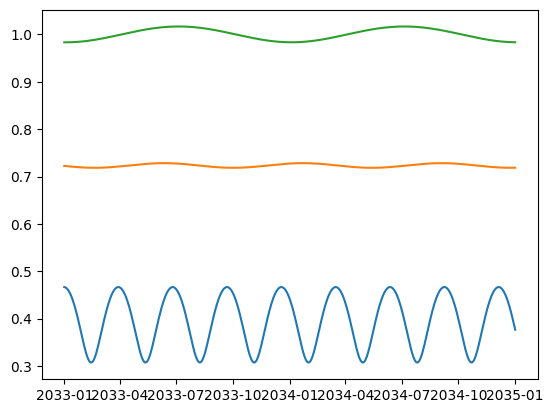

In [2]:
#use two arbitray years for the planets
start=datetime.datetime(2033,1,1)
end=datetime.datetime(2035,1,1)

times = [] 
dt=24 #time resolution for planets is 1 day
# Generate datetimes with increments of dt hours until the end date
current = start
while current <= end:
    times.append(current)
    current += datetime.timedelta(hours=dt)
    

def cart2sphere_rad(x,y,z):
    
    r = np.sqrt(x**2+ y**2 + z**2) / au
    theta = np.arctan2(z,np.sqrt(x**2+ y**2)) * 360 / 2 / np.pi
    phi = np.arctan2(y,x) * 360 / 2 / np.pi    
    
    theta=np.deg2rad(theta)
    phi=np.deg2rad(phi)
    
    return (r, theta, phi)

def generic_furnish(kernels_path):
    generic_path = kernels_path
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)    
    #spiceypy.furnsh(os.path.join(generic_path, 'de442.bsp'))
        
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))
        
def get_planet_pos(t,kernels_path, planet):
    if spiceypy.ktotal('ALL') < 1:
        generic_furnish(kernels_path)
    pos = spiceypy.spkpos(planet, spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position

def get_planet_positions(time_series,kernels_path,planet):
    positions = []
    for t in time_series:
        position = get_planet_pos(t,kernels_path, planet)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


# make Earth Mercury and Venus positions
generic_furnish(kernels_path)    
print(kernels_path)
mercury=get_planet_positions(times,kernels_path, 'MERCURY_BARYCENTER')
venus=get_planet_positions(times,kernels_path, 'VENUS_BARYCENTER')
earth=get_planet_positions(times,kernels_path, 'EARTH_BARYCENTER')

#to matplotlib datenumber
#mercury.time=mdates.date2num(mercury.time)
#venus.time=mdates.date2num(venus.time)
#earth.time=mdates.date2num(earth.time)

plt.plot(mercury.time,mercury.r,'-')
plt.plot(venus.time,venus.r,'-')
plt.plot(earth.time,earth.r,'-')


### CR3BP simulation (circular restricted 3 Body Problem)

equations adapted from https://jan.ucc.nau.edu/~ns46/student/2010/Frnka_2010.pdf

In [3]:
def cr3bp_equations(t, state):
    """
    Equations of motion for the Circular Restricted 3-Body Problem
    in the rotating reference frame with physical units.    
    state = [x, y, vx, vy] in km and km/s
    """
    x, y, vx, vy = state
    
    # Positions of the primaries in rotating frame
    x1 = -mu * au  # Sun position
    x2 = (1 - mu) * au  # Earth position
    
    # Distances to the two primaries
    r1 = np.sqrt((x - x1)**2 + y**2)
    r2 = np.sqrt((x - x2)**2 + y**2)
    
    # need to check these equations with Frnka 2010
    ax = (2*omega*vy + omega**2*x - G*M_sun*(x - x1)/r1**3 - G*M_earth*(x - x2)/r2**3)    
    ay = (-2*omega*vx + omega**2*y - G*M_sun*y/r1**3 - G*M_earth*y/r2**3)
    
    return [vx, vy, ax, ay]


def make_dro(initial_state):

    years=2
    days = 365*years  # Simulate for 1 year
    t_span = (0, days * 86400)      # Time span for integration (in seconds)
    t_eval = np.linspace(t_span[0], t_span[1], days*24) #time resolution is 1 hour, need to include better for arbitrary time arrays

    print("Integration started")
    # Solve the differential equations
    solution = solve_ivp(cr3bp_equations, t_span, initial_state,  t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-8)

    # Extract trajectory, convert to au
    x = solution.y[0]/au; y = solution.y[1]/au

    return x,y


### Numerical simulation

Integration started
Integration started
Integration started
Integration started
Integration started
[np.float64(0.9500000000000001), np.float64(0.9), np.float64(0.85), np.float64(0.8), np.float64(0.75)]
[3.03, 6.13, 9.33, 12.65, 16.11]
done
done


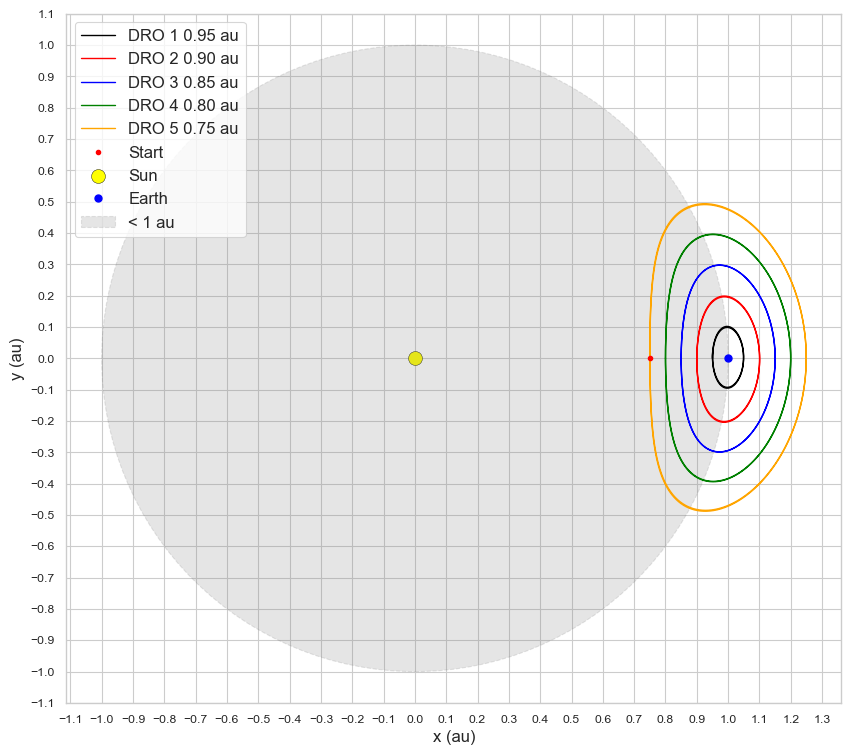

In [4]:
###################### find dro solutions by trial and error
######### ****** need to add specific times for orbits


#list for initial conditions
initial_x0_array=[]
initial_vy_array=[]

########### solution for 0.95 au is 3.03 km/s
x0 = 0.95*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 3.03 # km/s
[x1,y1]=make_dro([x0, y0, vx0, vy0])
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.9 au is 6.13 km/s
x0 = 0.90*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 6.13 # km/s
[x2,y2]=make_dro([x0, y0, vx0, vy0])
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.85 au is 9.33 km/s
x0 = 0.85*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 9.33 # km/s
[x3,y3]=make_dro([x0, y0, vx0, vy0])
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.8 au is 12.65 km/s
x0 = 0.8*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 12.65 # km/s
[x4,y4]=make_dro([x0, y0, vx0, vy0])
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.75 au is 16.11 km/s
x0 = 0.75*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 16.11 # km/s

[x5,y5]=make_dro([x0, y0, vx0, vy0])
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


print(initial_x0_array)
print(initial_vy_array)


print('done')

############# conversion for polar plot
dro_x1=x1
dro_y1=y1
dro_r1= np.sqrt(dro_x1**2 + dro_y1**2)
dro_lon1 = np.arctan2(dro_y1, dro_x1)

dro_x2=x2
dro_y2=y2
dro_r2= np.sqrt(dro_x2**2 + dro_y2**2)
dro_lon2 = np.arctan2(dro_y2, dro_x2)

dro_x3=x3
dro_y3=y3
dro_r3= np.sqrt(dro_x3**2 + dro_y3**2)
dro_lon3 = np.arctan2(dro_y3, dro_x3)

dro_x4=x4
dro_y4=y4
dro_r4= np.sqrt(dro_x4**2 + dro_y4**2)
dro_lon4 = np.arctan2(dro_y4, dro_x4)

dro_x5=x5
dro_y5=y5
dro_r5= np.sqrt(dro_x5**2 + dro_y5**2)
dro_lon5 = np.arctan2(dro_y5, dro_x5)


print('done')

############## quick visual check that the sim worked

sns.set_style('whitegrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

#third body
ax.plot(x1, y1, 'black', linewidth=1, alpha=1.0, label='DRO 1 0.95 au')
ax.plot(x2, y2, 'red', linewidth=1, alpha=1.0, label='DRO 2 0.90 au')
ax.plot(x3, y3, 'blue', linewidth=1, alpha=1.0, label='DRO 3 0.85 au')
ax.plot(x4, y4, 'green', linewidth=1, alpha=1.0, label='DRO 4 0.80 au')
ax.plot(x5, y5, 'orange', linewidth=1, alpha=1.0, label='DRO 5 0.75 au')



ax.plot(x0/au, y0/au, 'o', color='red', markersize=3, label='Start', zorder=4)

# Plot Sun - fixed at origin shifted by -mu*R
sun_x = -mu  
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3, label='Sun')
# Plot Earth - fixed at (1-mu)
earth_x = (1 - mu) 
ax.plot(earth_x, 0, 'o', color='blue', markersize=5, label='Earth', zorder=5)


# Add distance circles for reference
circle = plt.Circle((sun_x, 0), 1, fill=True, color='gray', linestyle='--', alpha=0.2, label='< 1 au')
#circle = plt.Circle((sun_x, 0), 0.72, fill=False, color='gold', linestyle='--', alpha=0.8, label='Venus orbit radius')


ax.add_patch(circle)
# Formatting
ax.set_xlabel('x (au)', fontsize=12)
ax.set_ylabel('y (au)', fontsize=12)
#ax.set_title(f'Circular Restricted 3-Body Problem: Sun-Earth System\n(Rotating Reference Frame, {days} days simulation)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True, alpha=1.0, linestyle='-')
ax.set_aspect('equal')

####### write orbits in pickle and txt files

###pickle files

#dro_x3,dro_y3,dro_r3,dro_lon3

file_dir='orbit_files'

#make recarrays
#dro1=
#dro2=
#dro3=
#dro4=
#dro5=


### find DRO solutions by minimization

In [5]:
######### *** to do - initial conditions plot against minimum distance after 1 revolution to find exact initial conditions

### DRO and planets plot


Number of SHIELD Spacecraft: 8
Interval in days: 45.625
longitudes: [  0.  14.  17.  11.  -0. -11. -17. -14.]


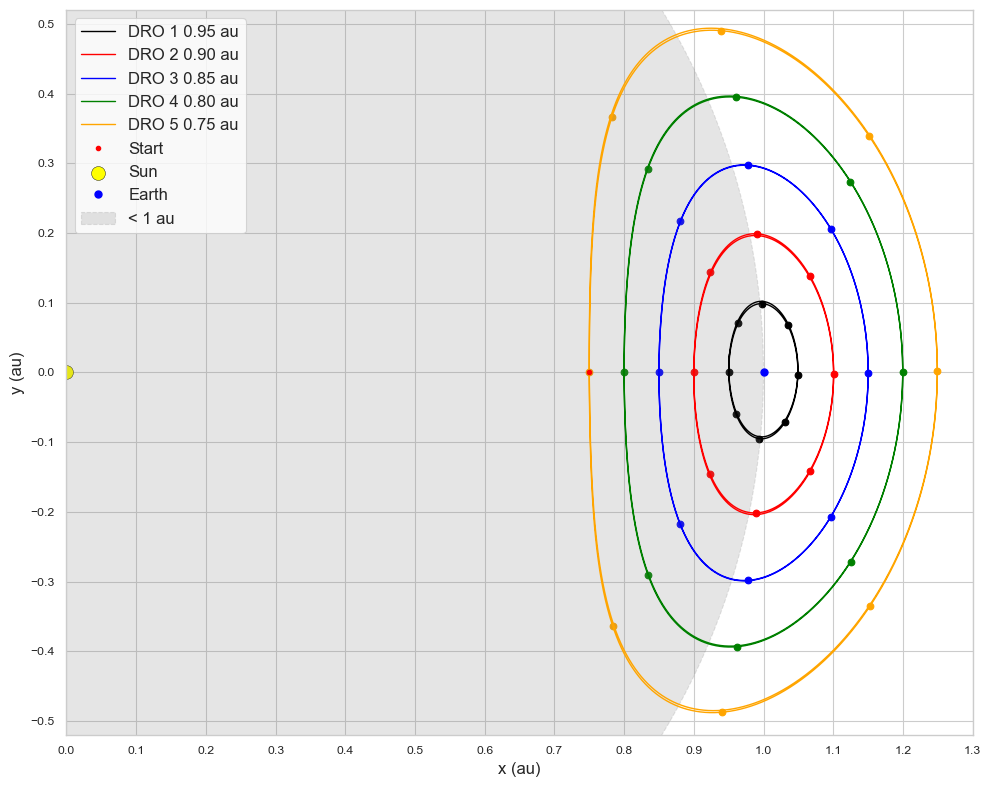

In [6]:


##plot spacecraft equidistant distribution on DRO 

#number of SHIELD spacecraft
nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))



sns.set_style('whitegrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

#third body
ax.plot(x1, y1, 'black', linewidth=1, alpha=1.0, label='DRO 1 0.95 au')
ax.plot(x2, y2, 'red', linewidth=1, alpha=1.0, label='DRO 2 0.90 au')
ax.plot(x3, y3, 'blue', linewidth=1, alpha=1.0, label='DRO 3 0.85 au')
ax.plot(x4, y4, 'green', linewidth=1, alpha=1.0, label='DRO 4 0.80 au')
ax.plot(x5, y5, 'orange', linewidth=1, alpha=1.0, label='DRO 5 0.75 au')


#with SHIELD distribution
ax.scatter(x1[shield_i],y1[shield_i],marker='o',c='black')
ax.scatter(x2[shield_i],y2[shield_i],marker='o',c='red')
ax.scatter(x3[shield_i],y3[shield_i],marker='o',c='blue')
ax.scatter(x4[shield_i],y4[shield_i],marker='o',c='green')
ax.scatter(x5[shield_i],y5[shield_i],marker='o',c='orange')



ax.plot(x0/au, y0/au, 'o', color='red', markersize=3, label='Start', zorder=4)

# Plot Sun - fixed at origin shifted by -mu*R
sun_x = -mu  
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3, label='Sun')
# Plot Earth - fixed at (1-mu)
earth_x = (1 - mu) 
ax.plot(earth_x, 0, 'o', color='blue', markersize=5, label='Earth', zorder=5)


# Add distance circles for reference
circle = plt.Circle((sun_x, 0), 1, fill=True, color='gray', linestyle='--', alpha=0.2, label='< 1 au')
#circle = plt.Circle((sun_x, 0), 0.72, fill=False, color='gold', linestyle='--', alpha=0.8, label='Venus orbit radius')


ax.add_patch(circle)
# Formatting
ax.set_xlabel('x (au)', fontsize=12)
ax.set_ylabel('y (au)', fontsize=12)
#ax.set_title(f'Circular Restricted 3-Body Problem: Sun-Earth System\n(Rotating Reference Frame, {days} days simulation)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True, alpha=1.0, linestyle='-')
ax.set_aspect('equal')
ax.set_xlim(0,1.3)
ax.set_ylim(-0.52,0.52)


plt.tight_layout()

plt.savefig('results/dro_cartesian_all.png', dpi=300,bbox_inches='tight')
plt.show()

## Plots for DRO characteristics

Slope: -65.3600
Intercept: 65.0060
R-squared: 0.9995
P-value: 4.3692e-06
Standard error: 0.8211


(0.0, 20.0)

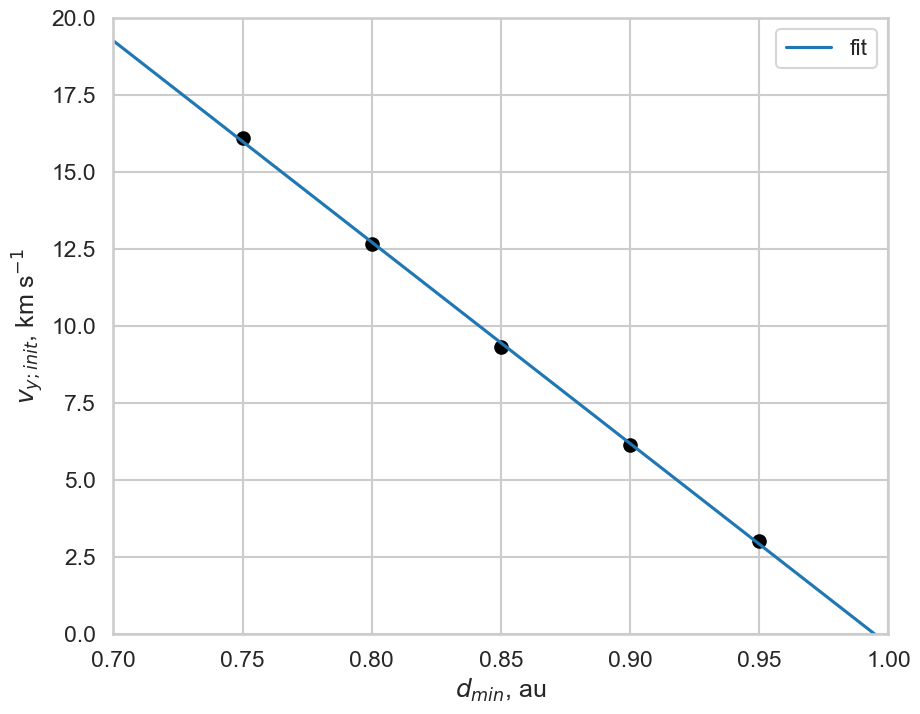

In [7]:
########### plot for initial speed and minimum distance to Sun

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(initial_x0_array, initial_vy_array)

# Print results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")

x_fit = np.arange(0.7,1.0,0.01)
y_fit = x_fit*slope + intercept


################################################## Create plots 
sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),dpi=100)   



########### dependence of initial vy peed on heliocentric distance
ax.scatter(initial_x0_array, initial_vy_array, c='black')

ax.plot(x_fit, y_fit, label='fit')

ax.legend()
ax.set_xlabel('$d_{min}$, au')
ax.set_ylabel('$v_{y;init}$, km s$^{-1}$')

ax.set_xlim(0.7, 1.0)
ax.set_ylim(0,20)

Slope: -1.9623
Intercept: 1.9658
R-squared: 1.0000
P-value: 2.0511e-08
Standard error: 0.0041

[ 5.8532965  11.44826803 17.2241552  23.10383876 29.04301386]
Slope: -116.0640
Intercept: 115.9873
R-squared: 0.9999
P-value: 6.8643e-07
Standard error: 0.7866


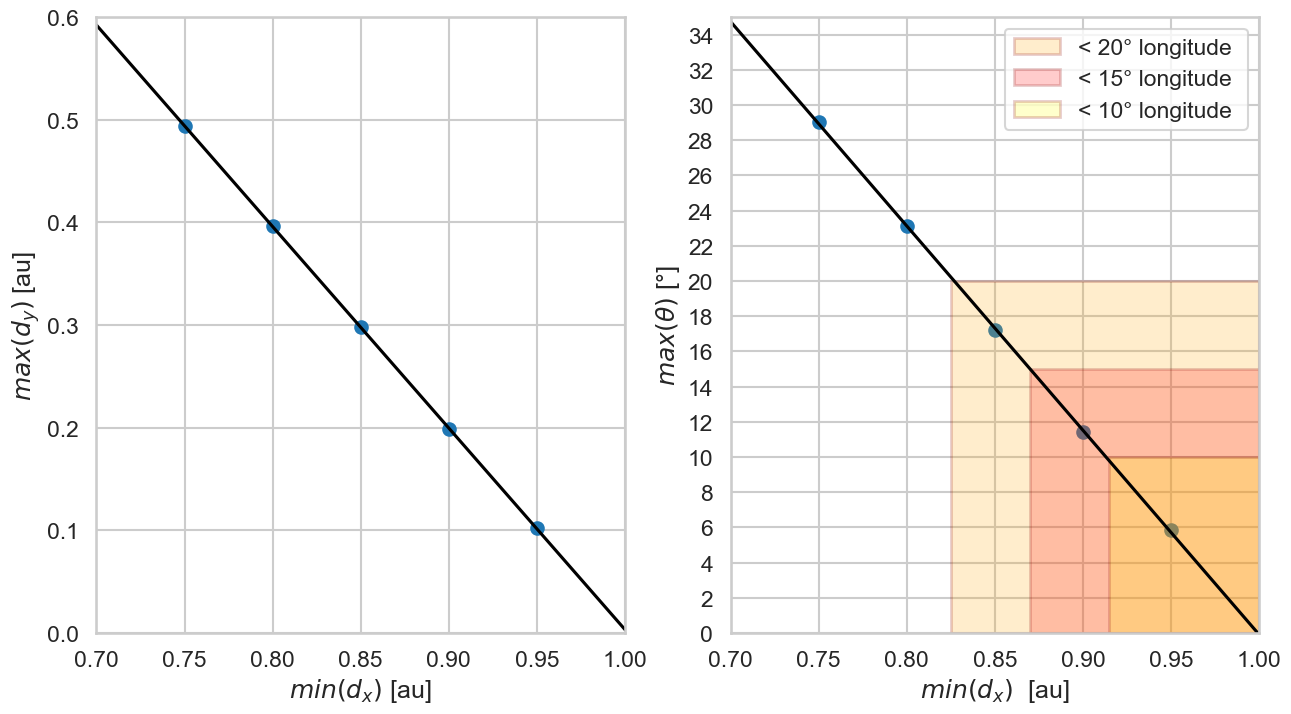

In [8]:
####### relationship between minimum distance and widest point in y in au 
sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 8),dpi=100)


min_dro_x1_arr=np.array([np.min(dro_x1),np.min(dro_x2),np.min(dro_x3),np.min(dro_x4),np.min(dro_x5)])
max_dro_y1_arr=np.array([np.max(dro_y1),np.max(dro_y2),np.max(dro_y3),np.max(dro_y4),np.max(dro_y5)])

ax1.scatter(min_dro_x1_arr,max_dro_y1_arr)
ax1.set_xlabel('$min(d_{x})$ [au]')
ax1.set_ylabel('$max(d_{y})$ [au]')
ax1.set_xlim(0.7, 1.0)
ax1.set_ylim(0,0.6)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(min_dro_x1_arr, max_dro_y1_arr)

# Print results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")

y_fit1 = x_fit*slope + intercept
ax1.plot(x_fit,y_fit1, c='k')




print()


####### relationship between minimum distance and widest point in y in longitude
max_dro_lon_arr=np.array(np.rad2deg([np.max(dro_lon1),np.max(dro_lon2),np.max(dro_lon3),np.max(dro_lon4),np.max(dro_lon5)]))

print(max_dro_lon_arr)
ax2.scatter(min_dro_x1_arr,max_dro_lon_arr)
ax2.set_xlabel('$min(d_{x})$  [au]')
ax2.set_ylabel(r'$max( \theta )$ [°]')
ax2.set_xlim(0.7, 1.0)
ax2.set_ylim(0,35)
ax2.yaxis.set_major_locator(MultipleLocator(2))

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(min_dro_x1_arr, max_dro_lon_arr)

# Print results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")

y_fit2 = x_fit*slope + intercept
ax2.plot(x_fit,y_fit2, c='k')



from matplotlib.patches import Rectangle



# Rectangle((x_start, y_start), width, height)
box = Rectangle((0.825, 0), 0.175, 20, 
                facecolor='orange', 
                alpha=0.2,
                edgecolor='darkred',
                linewidth=2, label='< 20° longitude ')
ax2.add_patch(box)


# Rectangle((x_start, y_start), width, height)
box = Rectangle((0.87, 0), 0.15, 15, 
                facecolor='red', 
                alpha=0.2,
                edgecolor='darkred',
                linewidth=2, label='< 15° longitude ')
ax2.add_patch(box)


# Rectangle((x_start, y_start), width, height)
box = Rectangle((0.915, 0), 0.15, 10, 
                facecolor='yellow', 
                alpha=0.2,
                edgecolor='darkred',
                linewidth=2, label='< 10° longitude ')
ax2.add_patch(box)

ax2.legend()


Text(0, 0.5, 'longitude')

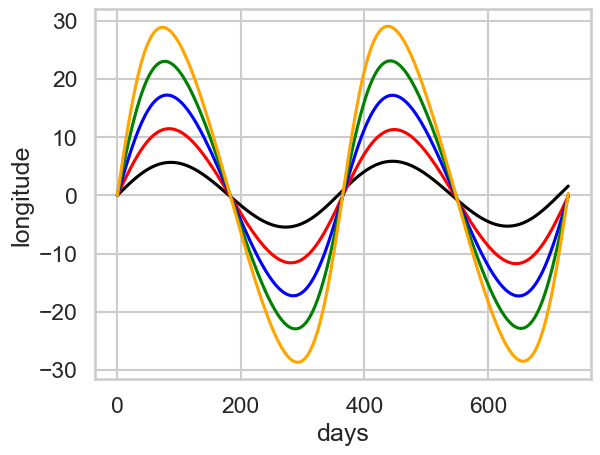

In [9]:
########## ORBITAL PERIOD Figure

#all take 1 year

#time axis same as for sim above in the function
years=2
days = 365*years  # Simulate for 1 year
t_span = (0, days * 86400)      # Time span for integration (in seconds)
t_eval = np.linspace(t_span[0], t_span[1], days*24) #time resolution is 1 hour, need to include better for arbitrary time arrays

plt.plot(t_eval/(86400),np.rad2deg(dro_lon1),c='black')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon2),c='red')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon3),c='blue')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon4),c='green')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon5),c='orange')


#with SHIELD distribution
#ax.scatter(x1[shield_i],y1[shield_i],marker='o',c='black')
#ax.scatter(x2[shield_i],y2[shield_i],marker='o',c='red')
#ax.scatter(x3[shield_i],y3[shield_i],marker='o',c='blue')
#ax.scatter(x4[shield_i],y4[shield_i],marker='o',c='green')
#ax.scatter(x5[shield_i],y5[shield_i],marker='o',c='orange')



plt.xlabel('days')
plt.ylabel('longitude')


### plot combined with planets in HEEQ

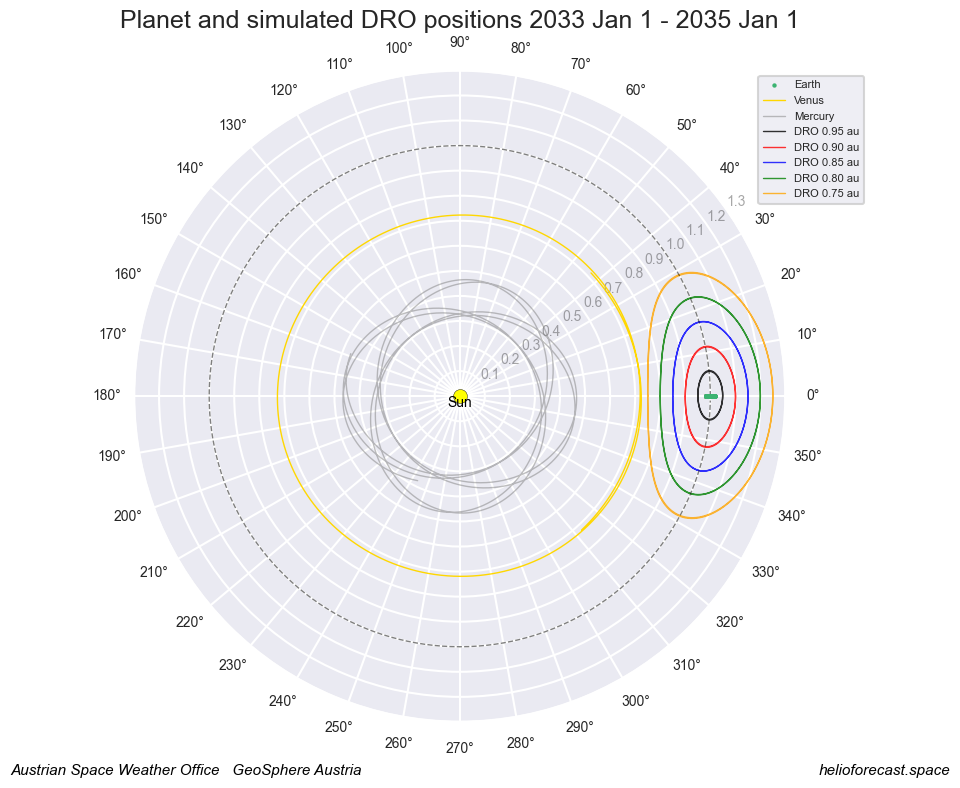

In [10]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')


# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)
    

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.5,linestyle='--',c='black', marker=None)
     
#set axes
ax.set_theta_zero_location('E')
plt.rgrids((0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.6,2.0,2.5),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3','1.6 AU','2.0','2.5'),angle=35, fontsize=fsize-5,alpha=0.4)

degrees = np.arange(0, 360, 10)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=10)

ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',fontsize=8)

plt.title('Planet and simulated DRO positions 2033 Jan 1 - 2035 Jan 1')
ax.set_ylim(0, 1.3) 
plt.tight_layout()


plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

     

plt.savefig('results/dro_all_polar.png', dpi=300,bbox_inches='tight')

### same plot zoomed in with spacecraft distribution

Number of SHIELD Spacecraft: 8
Interval in days: 45.625
longitudes: [  0.  14.  17.  11.  -0. -11. -17. -14.]


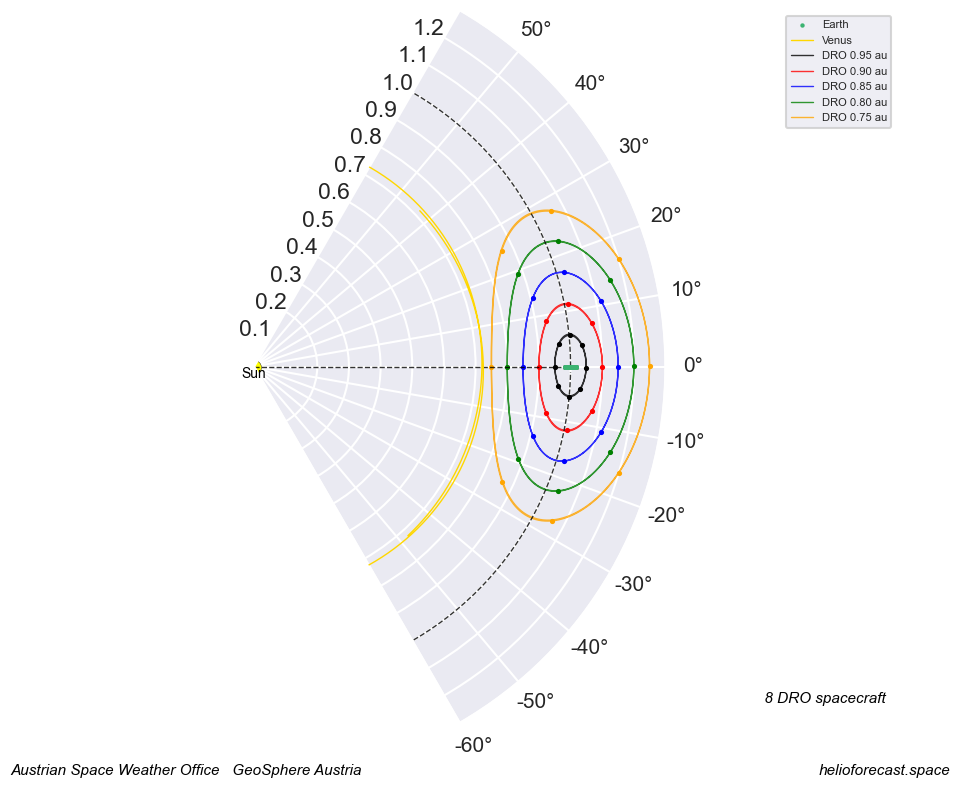

In [11]:
##plot spacecraft equidistant distribution on DRO 

#number of SHIELD spacecraft
nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
#ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


ax.scatter(dro_lon1[shield_i], dro_r1[shield_i],c='black', marker='o',s=5)
ax.scatter(dro_lon2[shield_i], dro_r2[shield_i],c='red', marker='o',s=5)
ax.scatter(dro_lon3[shield_i], dro_r3[shield_i],c='blue', marker='o',s=5)
ax.scatter(dro_lon4[shield_i], dro_r4[shield_i],c='green', marker='o',s=5)
ax.scatter(dro_lon5[shield_i], dro_r5[shield_i],c='orange', marker='o',s=5)

#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)
ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')




degrees = np.arange(-60,60,10)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

ax.set_rgrids(np.arange(0.2,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)


ax.set_theta_zero_location('E')
ax.set_thetamin(60)      # Start angle in degrees
ax.set_thetamax(-60)
##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
ax.set_ylim(0, 1.3) 


ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',fontsize=8)
plt.figtext(0.8,0.1,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

   
plt.savefig(f'results/dro_all_polar_zoom_{nr_sc}.png', dpi=300,bbox_inches='tight')

### Animations
use ffmpeg

plot spacecraft equidistant distribution on DRO 


In [12]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
############## number of SHIELD spacecraft #########
nr_sc=7
#################################################


t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


def make_frame(i):


    fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=200)    

    fsize=15
    symsize_planet=10

    ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
    #ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

    # Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

    ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
    ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
    #ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

    ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
    ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
    ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
    ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
    ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')
    

    #advance by factor frames

    ax.scatter(dro_lon1[shield_i+i*factor], dro_r1[shield_i+i*factor],c='black', marker='o',s=5)
    ax.scatter(dro_lon2[shield_i+i*factor], dro_r2[shield_i+i*factor],c='red', marker='o',s=5)
    ax.scatter(dro_lon3[shield_i+i*factor], dro_r3[shield_i+i*factor],c='blue', marker='o',s=5)
    ax.scatter(dro_lon4[shield_i+i*factor], dro_r4[shield_i+i*factor],c='green', marker='o',s=5)
    ax.scatter(dro_lon5[shield_i+i*factor], dro_r5[shield_i+i*factor],c='orange', marker='o',s=5)
    

    #1 au circle
    ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)

    ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')



    degrees = np.arange(-60,60,10)
    ax.set_xticks(np.radians(degrees))
    ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

    ax.set_rgrids(np.arange(0.2,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)


    ax.set_theta_zero_location('E')
    ax.set_thetamin(60)      # Start angle in degrees
    ax.set_thetamax(-60)
    ##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
    ax.set_ylim(0, 1.3) 

    #ax.set_rgrids((0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2'), angle=0, fontsize=5, alpha=0.1)
    ax.legend(bbox_to_anchor=(0.8, 1), loc='upper left',fontsize=10)
    plt.tight_layout()
    

    plt.figtext(0.2,0.8,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
    plt.figtext(0.2,0.75,f'time:   {np.round(i*factor/24,2)} days', color='black', ha='left',fontsize=fsize-4, style='italic')


    plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
    plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

    plt.savefig(f'results/frames/dro{i:04d}.jpg', dpi=200,bbox_inches='tight')
    plt.close()
    
    return 0

factor=12
make_frame(500)

Number of SHIELD Spacecraft: 7
Interval in days: 52.125
longitudes: [  0.  15.  16.   6.  -6. -16. -15.  -0.]


0

In [13]:
print()
print('make animation')
print()


ffmpeg_path=''
outputdirectory = 'results/frames'
animdirectory   = 'results/'

factor=12
i_all=int(365*24/factor) #365*24 for all frames for 1 year, 1 hour resolution, divided by factor
counter=[i for i in range(i_all)]

print('number of frames',i_all)

used=8
print('Using multiprocessing, nr of cores',mp.cpu_count(), \
      'with nr of processes used: ',used)

#define pool using fork and number of processes
pool=mp.get_context('fork').Pool(processes=used)
# Map the worker function onto the parameters    
t0 = time.time()
pool.map(make_frame, counter) #or use apply_async?,imap
pool.close()
pool.join()     
t1 = time.time()


print('time in sec: ',np.round((t1-t0),1))
print('plots done, frames saved in ',outputdirectory)


make animation

number of frames 730
Using multiprocessing, nr of cores 8 with nr of processes used:  8
time in sec:  25.9
plots done, frames saved in  results/frames


In [14]:
movie_filename=f'dro_{nr_sc}'
os.system(ffmpeg_path+'ffmpeg -r 25 -i '+str(outputdirectory)+'/dro%04d.jpg -b:v 5000k \
     '+str(animdirectory)+'/'+movie_filename+'.mp4 -y -loglevel quiet')    
print('movie done, saved in ',animdirectory)

os.system(ffmpeg_path+'ffmpeg -r 25 -i '+str(outputdirectory)+'/dro%04d.jpg -b:v 5000k \
     '+str(animdirectory)+'/'+movie_filename+'.gif -y -loglevel quiet')    



movie done, saved in  results/


0

### make one movie with HCI coordinates (transform from HEEQ to HCI)

In [ ]:
## TBD

### load ICMECAT


Number of SHIELD Spacecraft: 8
Interval in days: 45.625
longitudes: [  0.  14.  17.  11.  -0. -11. -17. -14.]


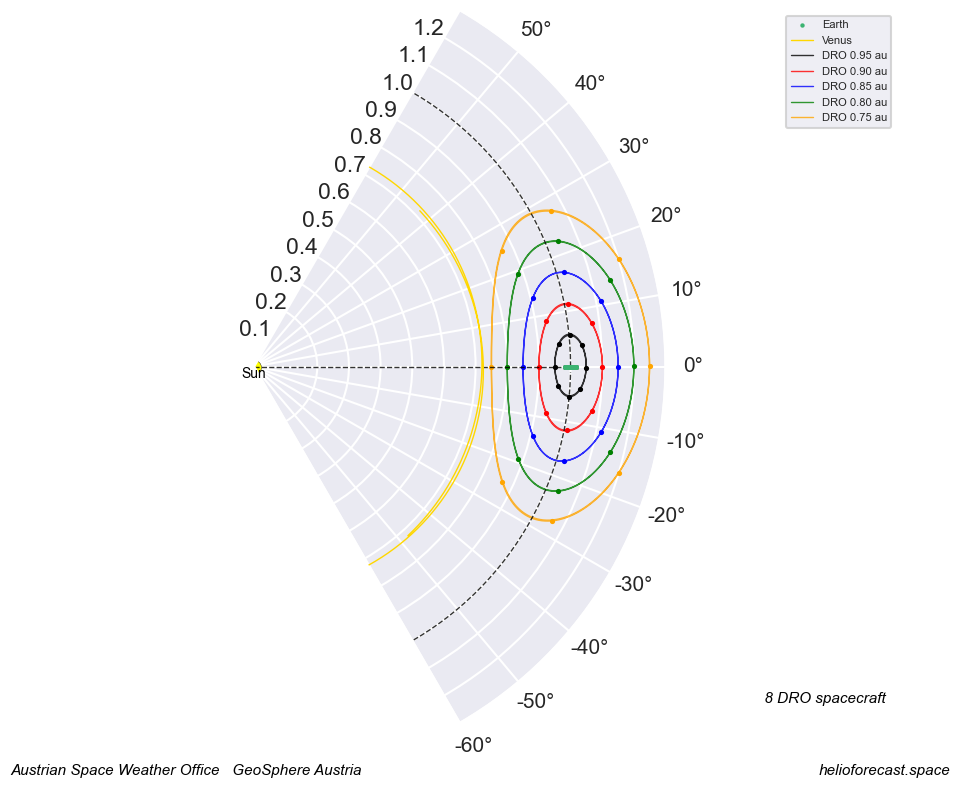

In [11]:
##plot spacecraft equidistant distribution on DRO 

#number of SHIELD spacecraft
nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
#ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


ax.scatter(dro_lon1[shield_i], dro_r1[shield_i],c='black', marker='o',s=5)
ax.scatter(dro_lon2[shield_i], dro_r2[shield_i],c='red', marker='o',s=5)
ax.scatter(dro_lon3[shield_i], dro_r3[shield_i],c='blue', marker='o',s=5)
ax.scatter(dro_lon4[shield_i], dro_r4[shield_i],c='green', marker='o',s=5)
ax.scatter(dro_lon5[shield_i], dro_r5[shield_i],c='orange', marker='o',s=5)

#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)
ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')




degrees = np.arange(-60,60,10)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

ax.set_rgrids(np.arange(0.2,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)


ax.set_theta_zero_location('E')
ax.set_thetamin(60)      # Start angle in degrees
ax.set_thetamax(-60)
##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
ax.set_ylim(0, 1.3) 


ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',fontsize=8)
plt.figtext(0.8,0.1,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

   
plt.savefig(f'results/dro_all_polar_zoom_{nr_sc}.png', dpi=300,bbox_inches='tight')